In [6]:
# pip install dash

# Introduction

In [7]:
#importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
from datetime import datetime as dt1
import plotly.express as px


In [8]:
countries = pd.read_csv("/kaggle/input/fraudsters-detection/countries.csv")
currency_details = pd.read_csv("/kaggle/input/fraudsters-detection/currency_details.csv")
transactions = pd.read_csv("/kaggle/input/fraudsters-detection/transactions.csv")
users = pd.read_csv("/kaggle/input/fraudsters-detection/users.csv")


In [9]:
#this stops data truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [10]:
print("Total records in users data frame " + str(len(users)))
print("Total records in transaction data frame " + str(len(transactions)))
print("Total records in countries data frame " + str(len(countries)))
print("Total records in currency_details data frame " + str(len(currency_details)))


Total records in users data frame 9944
Total records in transaction data frame 688651
Total records in countries data frame 226
Total records in currency_details data frame 184


# **Stiching Data Together**

In [11]:
cust = users.merge(transactions,left_on = 'ID',right_on='USER_ID',how='inner')

In [12]:
cust = cust.merge(countries,left_on = 'COUNTRY',right_on='CODE',how='inner')

In [13]:
customer_data =  cust.merge(currency_details,left_on = 'CURRENCY',right_on='CCY',how='inner')

In [14]:
#user status - STATE_x user_state
#transaction status - STATE_y transaction_state
# user id - ID_x	user_id
# transaction id - ID_y transaction_id
# user creation date - CREATED_DATE_x user_creation_date
# transaction create date - CREATED_DATE_y transaction_creation_date

cols_rename = {'STATE_x' : 'user_state', "STATE_y":"transaction_state", "ID_x":'user_id',"ID_y":"transaction_id","CREATED_DATE_x":"user_creation_date","CREATED_DATE_y":"transaction_creation_date"}
customer_data.rename(columns= cols_rename,inplace=True)

In [15]:
customer_data.drop(['USER_ID'], axis=1, inplace = True)


In [16]:
customer_data = customer_data.loc[:, ~customer_data.columns.duplicated()]

In [17]:
#lowercasing dataframe headers
customer_data.columns = [x.lower() for x in customer_data.columns]

In [18]:
# reducing columns - code,ccy
customer_data.drop(['code','ccy'], axis=1, inplace = True)


In [19]:
customer_data.groupby(['is_fraudster'])['user_id'].count()

is_fraudster
False    624433
True      13914
Name: user_id, dtype: int64

In [20]:
customer_data.describe()

,has_email,birth_year,failed_sign_in_attempts,amount,amount_usd,numcode,phonecode,exponent
count,638347.000000,638347.000000,638347.000000,6.383470e+05,5.857320e+05,638347.000000,638347.000000,638347.000000
mean,0.989249,1984.943445,0.009341,3.249031e+04,6.861673e+03,641.720469,109.226206,2.002951
std,0.103129,9.885179,0.139696,2.381297e+06,7.504013e+04,232.344865,131.069434,0.188669
min,0.000000,1927.000000,0.000000,0.000000e+00,0.000000e+00,32.000000,30.000000,0.000000
25%,1.000000,1980.000000,0.000000,4.670000e+02,3.460000e+02,440.000000,44.000000,2.000000
50%,1.000000,1987.000000,0.000000,1.393000e+03,1.008000e+03,826.000000,44.000000,2.000000
75%,1.000000,1992.000000,0.000000,5.000000e+03,3.689000e+03,826.000000,48.000000,2.000000
max,1.000000,2000.000000,6.000000,9.000000e+08,1.641211e+07,826.000000,594.000000,8.000000


In [21]:
date_columns = ['user_creation_date','transaction_creation_date','terms_version']
customer_data[date_columns] = customer_data[date_columns].apply(pd.to_datetime, errors='coerce')

In [22]:
# customer_data.info()

In [23]:
print("Combined dataframes column count is " +str(len(customer_data.columns)))

Combined dataframes column count is 28


# Data Manipulation

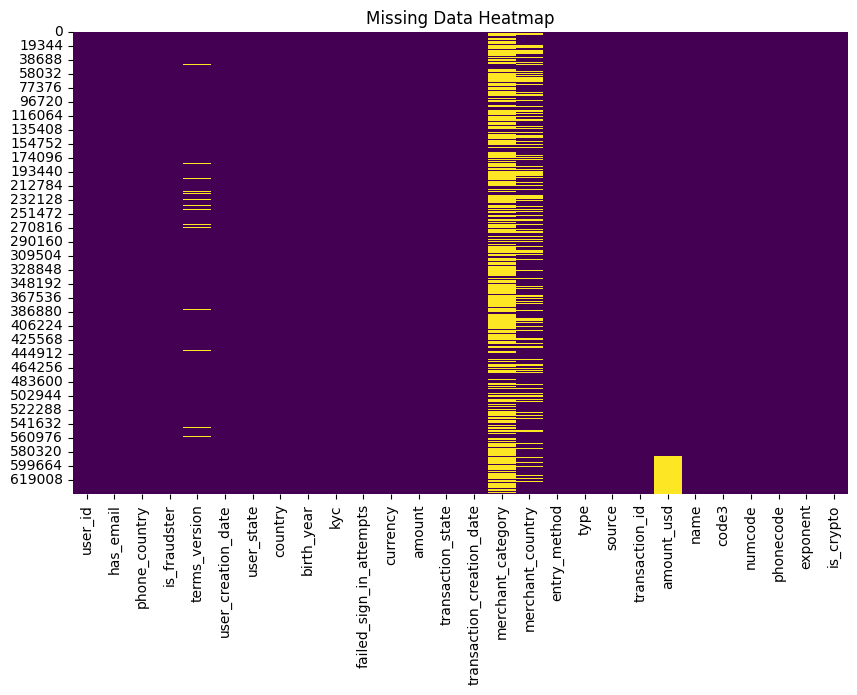

In [24]:
missing_data = customer_data.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(customer_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [25]:
print("More than 50% of values are null in Merchant country  " + str("{:.2%}".format((customer_data['merchant_category'].isnull().sum()/len(customer_data)))))


More than 50% of values are null in Merchant country  67.33%


In [26]:
# # (customer_data['amount_usd'].isnull().sum()/len(customer_data))*100
# customer_data.groupby('merchant_category')['user_id'].count().sort_values(byascending=False)
# customer_data.groupby(by=['merchant_category'], sort=False)['user_id'].count()
(customer_data['terms_version'].isnull().sum()/len(customer_data))*100

4.019443970129099

In [27]:
customer_data.groupby(by=['terms_version'], sort=False)['user_id'].count()

terms_version
2018-05-25    212956
2018-01-01      7345
2018-09-20    298402
2018-03-20     78452
2017-01-16      6844
2017-02-02      3105
2018-01-13      5585
Name: user_id, dtype: int64

In [28]:
df = customer_data

In [29]:
df['merchant_category'].fillna(df['merchant_category'].mode()[0], inplace=True)

In [30]:
# df['amount_usd'] = df['amount_usd'].map('${:,.2f}'.format)
# Define the bins and labels for bucketing in terms of amounts
bins = [0, 1000, 1000000, 1000000000, float('inf')]  # Bins for transaction amounts
labels = ['Hundreds', 'Thousands', 'Millions', 'Billions']  # Labels for bins

# Create a new column 'Transaction_Category' based on bucketed amounts
df['Transaction_Category'] = pd.cut(df['amount_usd'], bins=bins, labels=labels, right=False)

In [31]:
# df['user_creation_quarter'] = df['user_creation_date'].dt.quarter

In [32]:
df['user_creation_year'] = df['user_creation_date'].dt.year
df['user_creation_month'] = df['user_creation_date'].dt.month

In [33]:
df['transaction_creation_quarter'] = df['transaction_creation_date'].dt.quarter
df['transaction_creation_year'] = df['transaction_creation_date'].dt.year
df['transaction_creation_month'] = df['transaction_creation_date'].dt.month

In [34]:
df['terms_version_quarter'] = df['terms_version'].dt.quarter
df['terms_version_year'] = df['terms_version'].dt.year
df['terms_version_month'] = df['terms_version'].dt.month

In [35]:
df.drop(['user_creation_date','transaction_creation_date','terms_version'], axis=1, inplace = True)


In [36]:
df.drop(['phone_country','phonecode','numcode','exponent'], axis=1, inplace = True)


In [37]:
df.drop(['country'], axis=1, inplace = True)


In [38]:
df.drop(['code3'], axis=1, inplace = True)


In [39]:
# df.groupby('code3',sort=False)['user_id'].count()

In [40]:
cols_rename = {'name' : 'country'}
df.rename(columns= cols_rename,inplace=True)

In [41]:
current_year = dt1.now().year
df['user_age'] = current_year - df['birth_year']

In [42]:
df.drop(['birth_year'], axis=1, inplace = True)


In [43]:
df.head()

,user_id,has_email,is_fraudster,user_state,kyc,failed_sign_in_attempts,currency,amount,transaction_state,merchant_category,merchant_country,entry_method,type,source,transaction_id,amount_usd,country,is_crypto,Transaction_Category,user_creation_year,user_creation_month,transaction_creation_quarter,transaction_creation_year,transaction_creation_month,terms_version_quarter,terms_version_year,terms_version_month,user_age
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,False,ACTIVE,PASSED,0,GBP,50000,COMPLETED,point_of_interest,NaN,misc,TOPUP,HERA,29df55ae-accd-47c2-85f6-ed499703b75d,37130.0,United Kingdom,False,Thousands,2017,8,2.0,2018.0,5.0,2.0,2018.0,5.0,52
1,1872820f-e3ac-4c02-bdc7-727897b60043,1,False,ACTIVE,PASSED,0,GBP,1000,COMPLETED,point_of_interest,NaN,misc,TOPUP,HERA,1a050680-bb84-436f-a93b-79b7e75775db,749.0,United Kingdom,False,Hundreds,2017,8,3.0,2017.0,8.0,2.0,2018.0,5.0,52
2,1872820f-e3ac-4c02-bdc7-727897b60043,1,False,ACTIVE,PASSED,0,GBP,100,REVERTED,point_of_interest,NaN,misc,TOPUP,HERA,826381fe-8248-4616-993d-ceb52fb04807,74.0,United Kingdom,False,Hundreds,2017,8,3.0,2017.0,8.0,2.0,2018.0,5.0,52
3,545ff94d-66f8-4bea-b398-84425fb2301e,1,False,ACTIVE,PASSED,0,GBP,500,COMPLETED,point_of_interest,NaN,misc,P2P,INTERNAL,40ad821f-db81-4f8f-b7c6-6d7acc50e836,376.0,United Kingdom,False,Hundreds,2017,3,3.0,2018.0,7.0,1.0,2018.0,1.0,41
4,545ff94d-66f8-4bea-b398-84425fb2301e,1,False,ACTIVE,PASSED,0,GBP,499,COMPLETED,point_of_interest,NaN,misc,P2P,INTERNAL,b0c2b678-fe57-4ced-b03c-43178c5834bd,375.0,United Kingdom,False,Hundreds,2017,3,3.0,2018.0,7.0,1.0,2018.0,1.0,41


In [44]:
# check  = df[df['user_id'] == '545ff94d-66f8-4bea-b398-84425fb2301e']
# check.groupby('transaction_id',sort=False)['user_id'].count()
len(df.columns)

28

In [45]:
grouped = df.groupby('country')['user_id'].nunique().nlargest(5).reset_index()
fig = px.bar(grouped,x='country', y='user_id', height=400, title = 'Top 5 Unique Users volume Distribution across Countries',color='country')
fig.show()

In [46]:
df.columns

Index(['user_id', 'has_email', 'is_fraudster', 'user_state', 'kyc',
       'failed_sign_in_attempts', 'currency', 'amount', 'transaction_state',
       'merchant_category', 'merchant_country', 'entry_method', 'type',
       'source', 'transaction_id', 'amount_usd', 'country', 'is_crypto',
       'Transaction_Category', 'user_creation_year', 'user_creation_month',
       'transaction_creation_quarter', 'transaction_creation_year',
       'transaction_creation_month', 'terms_version_quarter',
       'terms_version_year', 'terms_version_month', 'user_age'],
      dtype='object')

In [47]:
grouped = df.groupby("is_fraudster")['user_id'].nunique().reset_index()
fig = px.pie(grouped, names='is_fraudster', values='user_id',title = 'Fraudster Tagging',color = 'is_fraudster')
fig.show()

In [48]:
grouped = df.groupby('is_fraudster')['amount_usd'].mean().reset_index()
fig = px.bar(grouped,x='is_fraudster', y='amount_usd', height=400, title = 'Average Transaction Amounts USD across Fraudster Tags',color='is_fraudster')
fig.show()


In [49]:
grouped = df.groupby('is_fraudster')['transaction_id'].count().reset_index()
fig = px.bar(grouped,x='is_fraudster', y='transaction_id', height=400, title = 'Transactions distributions across Fraudster Tags',color='is_fraudster')
fig.show()


In [50]:
grouped = df.groupby('Transaction_Category')['transaction_id'].count().reset_index()
fig = px.bar(grouped,x='Transaction_Category', y='transaction_id', height=400, title = 'Transactions distributions across Fraudster Tags',color='Transaction_Category')
fig.show()


In [51]:
# df.head()

# **Insights from Fraudsters data**

In [52]:
df_fraudster = df[df['is_fraudster'] == True]

In [53]:
print("Fraudster counts "+str(len(df_fraudster)))


Fraudster counts 13914


In [54]:
print("Unique Fraudster counts "+str(df_fraudster['user_id'].nunique()))


Unique Fraudster counts 297


In [55]:
grouped = df_fraudster.groupby('Transaction_Category')['user_id'].nunique().reset_index()
fig = px.bar(grouped,x='Transaction_Category', y='user_id', height=400, title = 'Fraudsters transaction distributions',color='Transaction_Category')
fig.show()


In [56]:
grouped = df_fraudster.groupby('kyc')['user_id'].nunique().nlargest(5).reset_index()

fig = px.bar(grouped,x='kyc', y='user_id', height=400, title = 'KYC Status of Fraudsters',color='kyc')
fig.show()


In [57]:
grouped = df_fraudster.groupby('country')['user_id'].nunique().nlargest(5).reset_index()
fig = px.bar(grouped,x='country', y='user_id', height=400, title = 'Country with most Fraudsters',color='country')
fig.show()


In [58]:
grouped = df_fraudster.groupby('country')['amount_usd'].mean().nlargest(5).reset_index()
fig = px.bar(grouped,x='country', y='amount_usd', height=400, title = 'Average fraud transaction amounts w.r.t countries',color='country')
fig.show()


In [59]:
grouped = df_fraudster.groupby('country')['amount_usd'].sum().nlargest(5).reset_index()
fig = px.bar(grouped,x='country', y='amount_usd', height=400, title = 'Fraud Transaction Sum amounts w.r.t countries',color='country')
fig.show()


In [60]:
grouped = df_fraudster.groupby('user_age')['user_id'].nunique().nlargest(5).reset_index()

fig = px.scatter(grouped,x='user_id',y='user_age',size = 'user_id',title = "Fraudsters Age Distributions",color='user_age')

fig.show()




In [61]:
# df_fraudster.groupby('user_age')['user_id'].nunique().nlargest(5)

In [62]:
grouped = df_fraudster.groupby('transaction_creation_quarter')['user_id'].count().nlargest(5).reset_index()
fig = px.pie(grouped,names='transaction_creation_quarter', values='user_id', height=400, title = "Most Fraud Transaction occurred over the Quarters",color='transaction_creation_quarter')
fig.show()


In [63]:
# grouped = df_fraudster.groupby('transaction_creation_quarter')['amount_usd'].sum().nlargest(5).reset_index()
# fig = px.pie(grouped,names='transaction_creation_quarter', values='amount_usd', height=400, title = "Fraud Transaction Sum amounts w.r.t quarter",color='transaction_creation_quarter')
# fig.show()

grouped = df_fraudster.groupby('transaction_creation_quarter').agg({'user_id':'nunique','amount_usd':'sum'}).reset_index()
# Create a Sunburst chart
grouped = grouped.rename(columns={'user_id': 'DistinctUserCount'})
fig = px.sunburst(grouped, path=['transaction_creation_quarter'], values='DistinctUserCount', title='Sunburst Chart with Distinct User Count and Transaction Sum',
                  hover_data=['DistinctUserCount'], color='amount_usd')
# Format the y-axis tick labels in billions
fig.update_layout(yaxis=dict(tickformat=",.2s"))
fig.show()
# grouped

In [64]:
grouped = df_fraudster.groupby('user_creation_year')['user_id'].count().nlargest(5).reset_index()
fig = px.pie(grouped,names='user_creation_year', values='user_id', height=400, title = "Most Fradulent Transaction occurred over the years",color='user_creation_year')
fig.show()


In [65]:
grouped = df_fraudster.groupby('user_creation_month')['user_id'].count().nlargest(5).reset_index()
fig = px.pie(grouped,names='user_creation_month', values='user_id', height=400, title = "Most Fraudulent Transaction occurred over the months",color='user_creation_month')
fig.show()


In [66]:
# grouped = df_fraudster.groupby('source')['amount_usd'].sum().nlargest(5).reset_index()
# fig = px.pie(grouped,names='source', values='amount_usd', height=400, title = "Top Sources where most Fraudulent Transaction occurred",color='source')
# fig.show()
grouped = df_fraudster.groupby(['merchant_category','source','type','entry_method'])['amount_usd'].sum().nlargest(5).reset_index()
fig = px.sunburst(grouped,path=['merchant_category','source','type','entry_method'], values='amount_usd', height=400, title = "Top Sources where most Fraudulent Transaction occurred")
fig.show()


In [67]:
grouped = df_fraudster.groupby(['transaction_creation_year','transaction_creation_quarter','transaction_creation_month']).agg({'transaction_id':'count','amount_usd':'sum'}).reset_index().rename(columns={'transaction_id':'Transaction Count','amount_usd':'Transaction Sum'})
fig = px.sunburst(grouped,path=['transaction_creation_year','transaction_creation_quarter','transaction_creation_month'], values='Transaction Count', height=400, title = "Transaction Distribution across Years",custom_data=['Transaction Count','Transaction Sum'])
fig.update_traces(
    hovertemplate='<b>Transaction Count:</b> %{customdata[0]}<br><b>Transaction Sum:</b> %{customdata[1]}'
)
fig.show()


In [68]:
grouped = df_fraudster.groupby('failed_sign_in_attempts')['user_id'].nunique().reset_index()
fig = px.pie(grouped,names='failed_sign_in_attempts', values='user_id', height=400, title = "Failed Sign in Attempts",color='failed_sign_in_attempts')
fig.show()


Here are my insights or feedbacks from the above data exploration. Bank must do something in these areas to curb fraudsters volume -


1.   KYC should be done more thorougly, the fraudsters tagged, most of them had their KYC passed
2.   Most fraudsters belong to United Kingdom
3.   An average fraud transaction amount size is greater in Poland, this means UK might be excelling in volume but the transaction sums are low for them
4.   The overall transaction sum for UK is high which is fine as the fraudster volume is way too high as compared to other countries.
5. Fraudsters belongs to 30-35 age group
6. Most transaction occured in the year 2017 & 2018.
7. Out of those years, most transactions occured 2 & 3 respectively.
8. Failed Sign in Attempts to 0 means that the user was actively aware of all the transactions he/she has done.




# **Insights from Non Fraudsters data**

In [69]:
df_non_fraudster = df[df['is_fraudster'] == False]

In [70]:
print("Non Fraudster counts "+str(len(df_non_fraudster)))


Non Fraudster counts 624433


In [71]:
print("Unique non-fraudulent customers "+str(df_non_fraudster['user_id'].nunique()))

Unique non-fraudulent customers 7437


In [72]:
grouped = df_non_fraudster.groupby('Transaction_Category')['user_id'].nunique().reset_index()
fig = px.bar(grouped,x='Transaction_Category', y='user_id', height=400, title = 'Non Fraudsters transaction distributions',color='Transaction_Category')
fig.show()


In [73]:
grouped = df_non_fraudster.groupby('kyc')['user_id'].nunique().nlargest(5).reset_index()

fig = px.bar(grouped,x='kyc', y='user_id', height=400, title = 'KYC Status of Non Fraudsters',color='kyc')
fig.show()


In [74]:
grouped = df_non_fraudster.groupby('country')['user_id'].nunique().nlargest(5).reset_index()
fig = px.bar(grouped,x='country', y='user_id', height=400, title = 'Country with most non Fraudsters',color='country')
fig.show()


In [75]:
grouped = df_non_fraudster.groupby('country')['amount_usd'].mean().nlargest(5).reset_index()
fig = px.bar(grouped,x='country', y='amount_usd', height=400, title = 'Average transaction amounts w.r.t countries',color='country')
fig.show()


In [76]:
grouped = df_non_fraudster.groupby('country')['amount_usd'].sum().nlargest(5).reset_index()
fig = px.bar(grouped,x='country', y='amount_usd', height=400, title = 'Transaction Sum amounts w.r.t countries',color='country')
fig.show()


In [77]:
grouped = df_non_fraudster.groupby('transaction_creation_quarter').agg({'user_id':'nunique','amount_usd':'sum'}).reset_index().rename(columns={'user_id':'Distinct User Count','amount_usd':'Transaction Sum'})
# Create a Sunburst chart
# grouped = grouped.rename(columns={'user_id': 'DistinctUserCount'})
fig = px.sunburst(grouped,
                  path=['transaction_creation_quarter'],
                  values='Distinct User Count', title='Sunburst Chart with Distinct User Count and Transaction Sum'
                  ,color='Transaction Sum',
                  custom_data=['Distinct User Count','Transaction Sum'])
fig.update_traces(
    hovertemplate='<b>Distinct User Count:</b> %{customdata[0]}<br><b>Transaction Sum:</b> %{customdata[1]}'
)
fig.show()
# grouped

In [78]:
grouped = df_non_fraudster.groupby('user_age')['user_id'].count().nlargest(5).reset_index()

fig = px.pie(grouped,names='user_age', values='user_id', height=400, title = "Age Distributions",color='user_age')
fig.show()



In [79]:
grouped = df_non_fraudster.groupby('transaction_creation_quarter')['user_id'].count().nlargest(5).reset_index()
fig = px.pie(grouped,names='transaction_creation_quarter', values='user_id', height=400, title = "Most Transaction occurred over the Quarters",color='transaction_creation_quarter')
fig.show()


In [80]:
grouped = df_non_fraudster.groupby('user_creation_year')['user_id'].count().nlargest(5).reset_index()
fig = px.pie(grouped,names='user_creation_year', values='user_id', height=400, title = "Most User Account creation occurred over the years",color='user_creation_year')
fig.show()


In [81]:
grouped = df_non_fraudster.groupby('user_creation_month')['user_id'].count().nlargest(5).reset_index()
fig = px.pie(grouped,names='user_creation_month', values='user_id', height=400, title = "Most Transaction occurred over the months",color='user_creation_month')
fig.show()


In [82]:
grouped = df_non_fraudster.groupby('user_age')['user_id'].nunique().nlargest(5).reset_index()

fig = px.scatter(grouped,x='user_id',y='user_age',size = 'user_id',title = "Fraudsters Age Distributions",color='user_age')

fig.show()




In [83]:
# df_non_fraudster.groupby('source')['transaction_id'].count().nlargest(5)
grouped = df_non_fraudster.groupby(['merchant_category','source','type','entry_method'])['amount_usd'].sum().nlargest(5).reset_index()
fig = px.sunburst(grouped,path=['merchant_category','source','type','entry_method'], values='amount_usd', height=400, title = "Top Sources where most Fraudulent Transaction occurred")
fig.show()


In [84]:
grouped = df_non_fraudster.groupby(['transaction_creation_year','transaction_creation_quarter','transaction_creation_month']).agg({'transaction_id':'count','amount_usd':'sum'}).reset_index().rename(columns={'transaction_id':'Transaction Count','amount_usd':'Transaction Sum'})
fig = px.sunburst(grouped,path=['transaction_creation_year','transaction_creation_quarter','transaction_creation_month'], values='Transaction Count', height=400, title = "Transaction Distribution across Years",custom_data=['Transaction Count','Transaction Sum'])
fig.update_traces(
    hovertemplate='<b>Transaction Count:</b> %{customdata[0]}<br><b>Transaction Sum:</b> %{customdata[1]}'
)
fig.show()
